In [4]:
import openpnm as op
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt

In [5]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=25e-6)

In [6]:
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

In [7]:
air = op.phases.Air(network=pn, name='air')
water = op.phases.Water(network=pn, name='water')

In [8]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geom)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geom)

In [9]:
OP_1 = op.algorithms.OrdinaryPercolation(network=pn)
OP_1.setup(phase=water, pore_volume='pore.volume', throat_volume='throat.volume')
OP_1.set_inlets(pn.pores('left'))
OP_1.run()

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.OrdinaryPercolation.set_inlets 
    TIME STAMP: 2019-05-21 21:23:33,447    


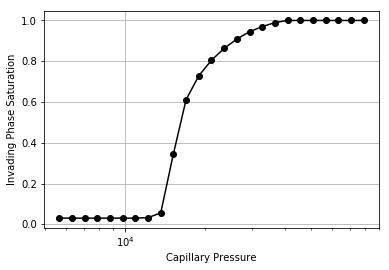

In [10]:
fig = OP_1.plot_intrusion_curve()

In [11]:
import openpnm.models.physics as pm
water.update(OP_1.results(Pc=10000))
air.update(OP_1.results(Pc=10000))
phys_air.add_model(model=pm.multiphase.conduit_conductance,
                   propname='throat.conduit_diffusive_conductance',
                   throat_conductance='throat.diffusive_conductance')
phys_water.add_model(model=pm.multiphase.conduit_conductance,
                     propname='throat.conduit_diffusive_conductance',
                     throat_conductance='throat.diffusive_conductance')

In [12]:
bounds = [['front', 'back'], ['left', 'right'], ['top', 'bottom']]
diff_air = {'0': [], '1': [], '2': []}
diff_water = {'0': [], '1': [], '2': []}
sat= []
tot_vol = np.sum(pn["pore.volume"]) + np.sum(pn["throat.volume"])
for Pc in np.unique(OP_1['pore.invasion_pressure']):
    water.update(OP_1.results(Pc=Pc))
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    phys_air.regenerate_models()
    phys_water.regenerate_models()
    this_sat = 0
    this_sat += np.sum(pn["pore.volume"][water["pore.occupancy"] == 1])
    this_sat += np.sum(pn["throat.volume"][water["throat.occupancy"] == 1])
    sat.append(this_sat)
    for bound_increment in range(len(bounds)):
        BC1_pores = pn.pores(labels=bounds[bound_increment][0])
        BC2_pores = pn.pores(labels=bounds[bound_increment][1])
        FD_1 = op.algorithms.FickianDiffusion(network=pn)
        FD_1.setup(phase=air, conductance='throat.conduit_diffusive_conductance')
        FD_1.set_value_BC(values=0.6, pores=BC1_pores)
        FD_1.set_value_BC(values=0.2, pores=BC2_pores)
        FD_1.run()
        eff_diff = FD_1.calc_effective_diffusivity(domain_area=2.5e-3, domain_length=0.25e-3)
        diff_air[str(bound_increment)].append(eff_diff)
        FD_2 = op.algorithms.FickianDiffusion(network=pn)
        FD_2.setup(phase=water, conductance='throat.conduit_diffusive_conductance')
        FD_2.set_value_BC(values=0.6, pores=BC1_pores)
        FD_2.set_value_BC(values=0.2, pores=BC2_pores)
        FD_2.run()
        eff_diff = FD_2.calc_effective_diffusivity(domain_area=2.5e-3, domain_length=0.25e-3)
        diff_water[str(bound_increment)].append(eff_diff)
        pn.project.purge_object(FD_1)
        pn.project.purge_object(FD_2)

In [13]:
sat = np.asarray(sat)
sat /= tot_vol
rel_diff_air_x    =  np.asarray(diff_air['0'])
rel_diff_air_x   /=  rel_diff_air_x[0]
rel_diff_air_y    =  np.asarray(diff_air['1'])
rel_diff_air_y   /=  rel_diff_air_y[0]
rel_diff_air_z    =  np.asarray(diff_air['2'])
rel_diff_air_z   /=  rel_diff_air_z[0]
rel_diff_water_x  =  np.asarray(diff_water['0'])
rel_diff_water_x /=  rel_diff_water_x[-1]
rel_diff_water_y  =  np.asarray(diff_water['1'])
rel_diff_water_y /=  rel_diff_water_y[-1]
rel_diff_water_z  =  np.asarray(diff_water['2'])
rel_diff_water_z /=  rel_diff_water_z[-1]

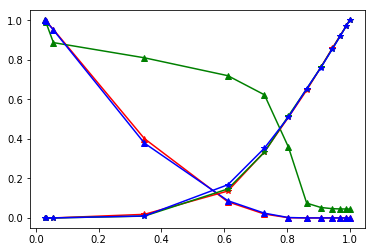

In [14]:
plots = []
plots.append(plt.plot(sat, rel_diff_air_x, '^-r', label='Dra_x'))
plots.append(plt.plot(sat, rel_diff_air_y, '^-g', label='Dra_y'))
plots.append(plt.plot(sat, rel_diff_air_z, '^-b', label='Dra_z'))
plots.append(plt.plot(sat, rel_diff_water_x, '*-r', label='Drw_x'))
plots.append(plt.plot(sat, rel_diff_water_y, '*-g', label='Drw_y'))
plots.append(plt.plot(sat, rel_diff_water_z, '*-b', label='Drw_z'))